In [1]:
import os

os.chdir("../../")

import pandas as pd
import neuralprophet as nprophet
from matplotlib import pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Make NeuralProphet deterministic
nprophet.set_random_seed(0)

#### Idea

Building a model that predicts the daily temperature over the next year based on the actual
temperatures over the last weeks and a professional forecast for the next days. Model will be mostly
informed by the learned seasonality **but will still include actual forecasts and current weather.**

In [17]:
temperatures = ingestion.read_temperatures()
temperatures.index.name = "ds"

temperatures = temperatures.rename("y").to_frame().reset_index()

# Split data into train and test
train = temperatures[temperatures["ds"] < "2019-01-01"]
test = temperatures[temperatures["ds"] >= "2019-01-01"]

# Create model
model = nprophet.NeuralProphet(
    n_forecasts=365,
    n_lags=15,
)

In [18]:
model.fit(train, freq="D")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 94
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (223) is too small than the required number for the learning rate finder (254). The results might not be optimal.


Finding best initial lr:   0%|          | 0/254 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,36.747494,46.502052,0.465230,0.0,0
1,30.171402,38.344341,0.343416,0.0,1
2,22.809528,28.733522,0.214261,0.0,2
3,15.967775,19.590433,0.108517,0.0,3
4,10.903924,13.090928,0.049605,0.0,4
...,...,...,...,...,...
89,2.727722,3.406838,0.003301,0.0,89
90,2.727156,3.406370,0.003301,0.0,90
91,2.727115,3.405645,0.003299,0.0,91
92,2.726970,3.405476,0.003298,0.0,92


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.737% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.737% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 223it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


<AxesSubplot: xlabel='ds'>

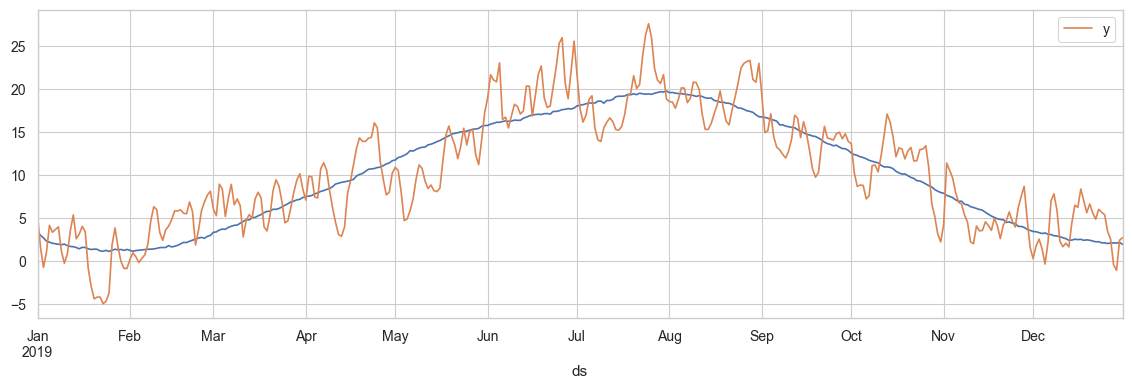

In [45]:
# Predict the temperature for a full year
future = model.make_future_dataframe(train, periods=365, n_historic_predictions=0)
prediction = model.predict(future)
latest_prediction = model.get_latest_forecast(prediction).set_index("ds")
actual = test.set_index("ds").loc["2019"]

# Plot the forecast
fig, ax = plt.subplots(figsize=(14, 4))

latest_prediction["origin-0"].plot(ax=ax, label="Prediction")
actual.plot(ax=ax, label="Actual")